In [39]:
import numpy as  np
import pandas as pd
import trackpy as tp
import matplotlib.pyplot as plt
import os
import numba
import seaborn as sns
from IPython.display import display, HTML
import helperfunctions # this is my own python file
from stdev_emsd import stdev_emsd, multi_stdev_emsd # this is my own python file

sns.set_context('poster')

In [7]:
# Please give all the files you want to combine.
filename_list = [r"C:\Users\vhorowit\Desktop\Sara Conti\Analysis\Data Taken 2024-07-22, 2024-07-22_ND4_ND8_1.avicontrol_tracer_nodrift.pkl",
                 r"C:\Users\vhorowit\Desktop\Sara Conti\Analysis\Data Taken 2024-07-22, 2024-07-22_ND4_ND8_3.avicontrol_tracer_nodrift.pkl"]

# please give the fps for all these files.
fps =        # for example, 50
# We cannot combine these files unless the fps are all the same.

# please give the microns per pixel for all these files.
scaling_list =   # for example, [1,1]

# Do you want to calculate the emsd of each file? or just calculate the combined emsd of all the files
calc_each_emsd = True

In [21]:
# stderr = stdev / sqrt(N)
def calc_stderr_for_emsd_df(emsd_df):
        # Calculate standard error from standard deviation
        stderr_msd = emsd_df.std_msd / np.sqrt(emsd_df.N)
        return emsd_df.assign(stderr_msd=stderr_msd)

In [22]:
# Create emsd dataframes with the following columns:
    # lagt = lag time, 
    # msd = ensemble mean square displacement, 
    # N = effective number of independent measurements, 
    # std_msd = standard deviation of mean square displacement
    # stderr_msd = standard error of mean square displacement
    # weight_msd = the weight to use in a weighted average of emsds

trajectories_list = [] # initialize list of dataframes
emsd_list = []
for filepath, scaling in zip(filename_list, scaling_list):
    traj = pd.read_pickle(filepath)
    trajectories_list.append(traj) # read trajectory files
    
    if calc_each_emsd:
        emsd_full_df = stdev_emsd(traj, mpp=scaling, fps = fps, detail = True)
        emsd_df = emsd_full_df[['lagt', 'msd', 'N', 'std_msd']]
        emsd_df = calc_stderr_for_emsd_df(emsd_df)
        
        emsd_list.append(emsd_df)   

if calc_each_emsd:
    # Create big dataframe named big_df to organize all these trajectories and their emsds.
    big_df = pd.DataFrame({'paths':filename_list, 
                           'files': [os.path.basename(filepath) for filepath in filename_list],   
                           'scaling': scaling_list, 
                           'trajectory': trajectories_list, 
                           'emsd': emsd_list})
    display(big_df)

,paths,files,scaling,trajectory,emsd
0,C:\Users\vhorowit\Desktop\Sara Conti\Analysis\...,"Data Taken 2024-07-22, 2024-07-22_ND4_ND8_1.av...",1,x y relative_to_fr...,lagt msd N std_...
1,C:\Users\vhorowit\Desktop\Sara Conti\Analysis\...,"Data Taken 2024-07-22, 2024-07-22_ND4_ND8_3.av...",1,x y relative_to_fr...,lagt msd N std_...


In [23]:
multi_emsd = multi_stdev_emsd(trajectories_list,scaling_list, fps, detail=True)
multi_emsd = calc_stderr_for_emsd_df(multi_emsd)

multi_emsd

,<x>,<y>,<x^2>,<y^2>,msd,N,lagt,std_<x>,std_<y>,std_<x^2>,std_<y^2>,std_msd,stderr_msd
frame,,,,,,,,,,,,,
1,0.001876,0.001654,0.497815,0.667600,1.165415,29385.048852,1.0,0.071363,0.066315,0.193580,0.376641,0.500810,0.002922
2,0.002918,0.000657,1.032627,1.249617,2.282244,19570.952549,2.0,0.095029,0.119909,0.208269,0.502721,0.609679,0.004358
3,-0.001761,0.001715,1.731794,1.958115,3.592806,13891.416968,3.0,0.144120,0.168607,0.382646,0.653769,0.860014,0.007297
4,0.003274,-0.001588,2.330569,2.578391,4.908960,10652.854213,4.0,0.169318,0.196256,0.411035,0.489283,0.736486,0.007136
5,0.001554,-0.012601,3.044079,3.335193,6.379272,8607.046102,5.0,0.218522,0.244958,0.557577,0.673426,0.984973,0.010617
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,-0.094277,-0.197490,72.503303,82.961775,148.705727,413.347143,96.0,3.651403,4.235093,33.981412,29.259947,45.419299,2.233999
97,-0.078507,-0.201109,74.629008,85.115885,150.484320,408.658808,97.0,3.742270,4.265359,34.903459,30.332321,46.796664,2.314912
98,-0.057308,-0.209434,74.057765,84.752300,151.905279,404.067103,98.0,3.784621,4.303228,35.662890,30.237604,47.800134,2.377948


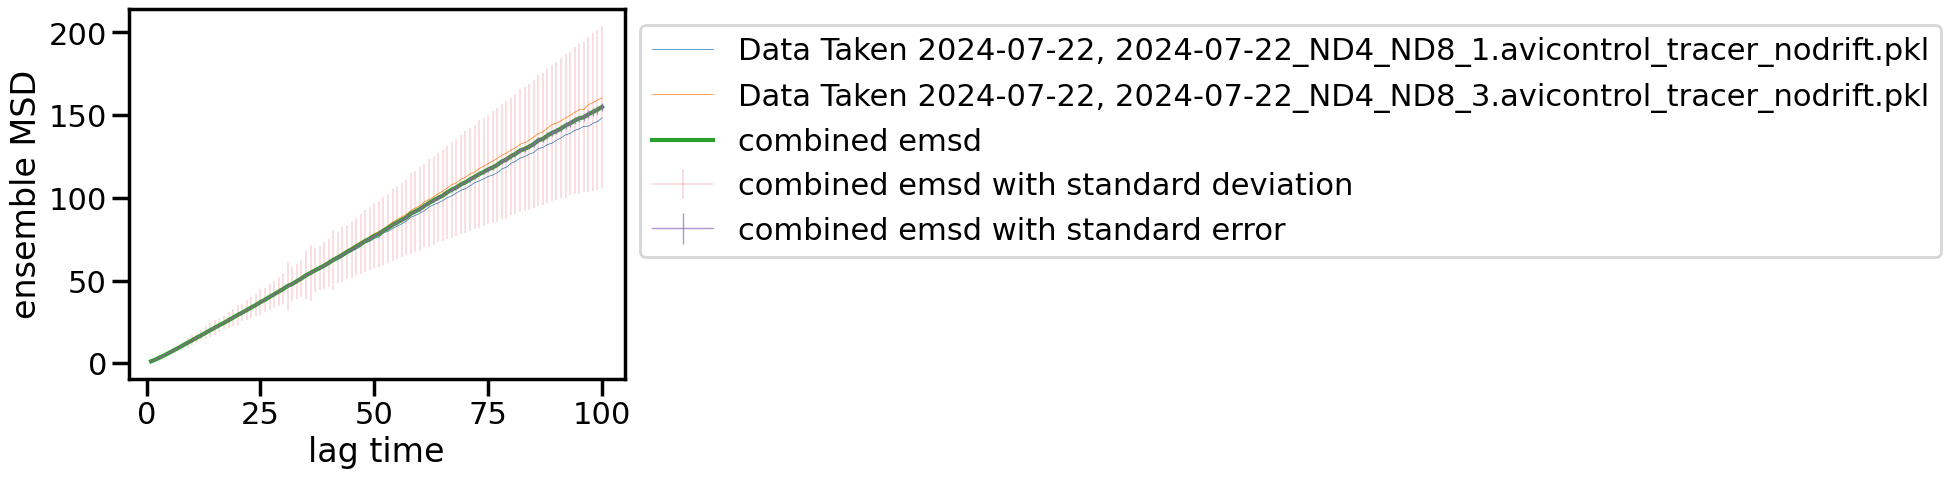

In [40]:
if calc_each_emsd:
    for emsd, file in zip(big_df.emsd, big_df.files):
        plt.plot(emsd.lagt, emsd.msd, linewidth=.5, label=file)

plt.plot(multi_emsd.lagt, multi_emsd.msd, label="combined emsd")
plt.errorbar(multi_emsd.lagt, 
             multi_emsd.msd, 
             yerr = multi_emsd.std_msd, 
             capthick=0, 
             alpha = 0.7,
             linewidth=.3,
             label="combined emsd with standard deviation")

plt.errorbar(multi_emsd.lagt, 
             multi_emsd.msd, 
             yerr = multi_emsd.stderr_msd, 
             capthick=0, 
             alpha = 0.7,
             linewidth=1,
             label="combined emsd with standard error")

plt.xlabel('lag time')
plt.ylabel('ensemble MSD')

plt.legend(bbox_to_anchor=(1, 1), loc='upper left');